In [1]:
#importing lib and data

import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
# model creation
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [4]:
# Training and testing
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.611..  Test Loss: 0.498..  Test Accuracy: 0.813
Epoch: 2/30..  Training Loss: 0.481..  Test Loss: 0.426..  Test Accuracy: 0.845
Epoch: 3/30..  Training Loss: 0.452..  Test Loss: 0.424..  Test Accuracy: 0.841
Epoch: 4/30..  Training Loss: 0.434..  Test Loss: 0.422..  Test Accuracy: 0.850
Epoch: 5/30..  Training Loss: 0.426..  Test Loss: 0.459..  Test Accuracy: 0.836
Epoch: 6/30..  Training Loss: 0.414..  Test Loss: 0.393..  Test Accuracy: 0.862
Epoch: 7/30..  Training Loss: 0.408..  Test Loss: 0.407..  Test Accuracy: 0.856
Epoch: 8/30..  Training Loss: 0.405..  Test Loss: 0.377..  Test Accuracy: 0.866
Epoch: 9/30..  Training Loss: 0.397..  Test Loss: 0.391..  Test Accuracy: 0.861
Epoch: 10/30..  Training Loss: 0.401..  Test Loss: 0.375..  Test Accuracy: 0.867
Epoch: 11/30..  Training Loss: 0.386..  Test Loss: 0.394..  Test Accuracy: 0.868
Epoch: 12/30..  Training Loss: 0.385..  Test Loss: 0.405..  Test Accuracy: 0.859
Epoch: 13/30..  Training Loss: 0.379.

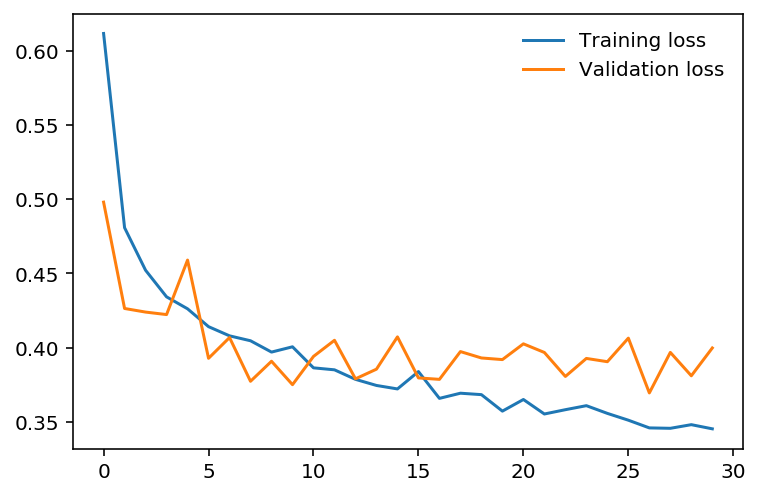

In [5]:
# Loss Graph

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Using Model to predict outcome

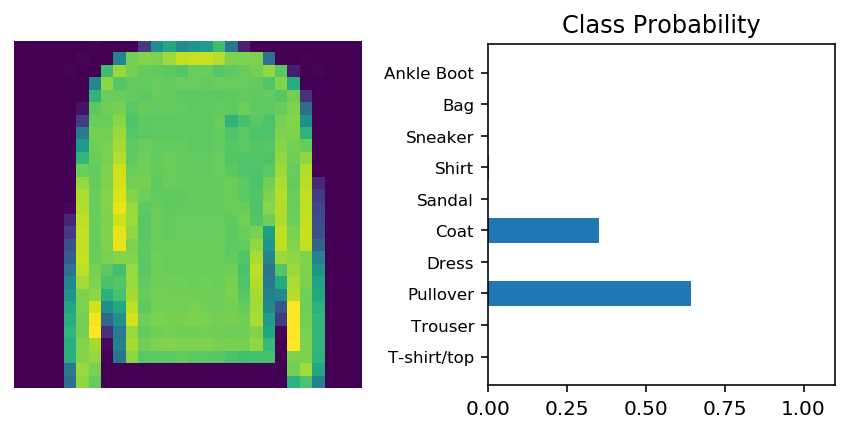

In [10]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

# Taking Random Input
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]

# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')